In [1]:
#| default_exp preprocessing

In [2]:
# | export

from allos.readers_tests import *



In [3]:
#| export
import scanpy as sc


def subset_common_cells( dataset1:sc.AnnData,  # First dataset to be subsetted.
                        dataset2:sc.AnnData   # Second dataset to compare with.
                        ) -> sc.AnnData:  # Subset of `dataset1` containing only cells also found in `dataset2`.
    
    "Subset `dataset1` to only include cells that are also present in `dataset2`."
    # Find common cells by intersecting the cell identifiers of both datasets
    common_cells = dataset1.obs_names.intersection(dataset2.obs_names)
    
    # Explicitly subset dataset1 to only include these common cells
    subset_dataset1 = dataset1[common_cells, :].copy()
    
    return subset_dataset1

In [4]:
#| export 

import pandas as pd
import anndata as ad

#| export
def transfer_obs(dataset1: ad.AnnData,  # Source AnnData object with .obs metadata to transfer.
                 dataset2: ad.AnnData   # Target AnnData object to receive .obs metadata.
                 ) -> ad.AnnData:       # The modified `dataset2` with .obs from `dataset1` transferred.
    "Transfer `.obs` metadata from `dataset1` to `dataset2` one by one, while preserving the `.var` DataFrame of `dataset2`."
    
    # Ensure dataset2's .var is preserved without altering its contents
    var_dataset2 = dataset2.var.copy()
    
    # Clear current .obs in dataset2 to ensure it only contains metadata from dataset1
    dataset2.obs = pd.DataFrame(index=dataset2.obs.index)
    
    # Loop through each column in dataset1.obs and transfer it to dataset2.obs
    for column_name in dataset1.obs.columns:
        # Transfer each column individually
        dataset2.obs[column_name] = dataset1.obs[column_name].copy()

    # Reapply the saved .var to dataset2 to ensure it's preserved
    dataset2.var = var_dataset2

    return dataset2

In [5]:
combined_mouse_data = process_mouse_data()


🔎 Looking for file at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File found at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz to /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt...
✅ Decompression complete.
Test data (mouse_1) downloaded successfully
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz to 

In [6]:
#| export
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix

def get_sot_gene_matrix(adata):
    """
    Construct a gene-level count matrix from transcript-level data.
    
    Parameters
    ----------
    adata : AnnData
        Input AnnData with transcript-level counts. Must have a column `geneId`
        in `adata.var` containing the gene ID for each transcript.
    
    Returns
    -------
    AnnData
        A new AnnData object where columns (var) represent unique genes, 
        and values are aggregated transcript counts.
    """
    # gene_ids must be something like adata.var['geneId']
    gene_ids = adata.var['geneId'].values
    
    # Find the unique gene IDs and map each transcript to one of these genes
    unique_gene_ids, inverse = np.unique(gene_ids, return_inverse=True)
    
    # Convert adata.X to a COO matrix (cheap if already sparse)
    X_coo = coo_matrix(adata.X)

    
    # Re-map the column indices: each old column index -> new gene index
    new_row = X_coo.row
    new_col = inverse[X_coo.col]
    new_data = X_coo.data
    
    # Build the new sparse matrix
    # (COO duplicates are summed when converting to CSR/CSC)
    new_coo = coo_matrix(
        (new_data, (new_row, new_col)),
        shape=(adata.n_obs, len(unique_gene_ids))
    )
    new_X = new_coo.tocsr()  # or .tocsc(), whichever you prefer
    
    # Build a new AnnData object at gene level
    adata_gene_level = sc.AnnData(
        X=new_X,
        obs=adata.obs.copy(),
        var=pd.DataFrame(index=unique_gene_ids)
    )

    adata_gene_level.var.index.names = ['geneId']

    
    return adata_gene_level


In [7]:
#| export
def compute_transcript_abundance_pct(adata):
    """
    Compute transcript abundance percentages ("percent spliced in") for each transcript 
    within its gene. For each cell and transcript, this is computed as:
    
        transcript_pct = (transcript count / total gene count) * 100
    
    Parameters
    ----------
    adata : AnnData
        AnnData object with transcript-level counts. Must have a column 'geneId' in adata.var.
    
    Returns
    -------
    AnnData
        A new AnnData object with the same obs and var as the input, where X holds 
        transcript abundance percentages.
    """
    gene_adata = get_sot_gene_matrix(adata)
    gene_ids = adata.var['geneId'].values
    _, inverse = np.unique(gene_ids, return_inverse=True)
    
    def to_dense(matrix):
        return matrix.toarray() if hasattr(matrix, "toarray") else matrix
    
    transcript_counts = to_dense(adata.X)
    gene_counts = to_dense(gene_adata.X)
    denominator = gene_counts[:, inverse]
    
    with np.errstate(divide='ignore', invalid='ignore'):
        pct = np.divide(
            transcript_counts,
            denominator,
            out=np.zeros_like(transcript_counts, dtype=float),
            where=denominator != 0
        )
    pct *= 100
    
    new_adata = sc.AnnData(X=pct, obs=adata.obs.copy(), var=adata.var.copy())
    return new_adata


In [8]:
#| export
def compute_whole_data_transcript_abundance(adata):
    """
    Compute transcript abundance percentages for the entire dataset by aggregating 
    transcript counts across all cells into a single composite sample.
    
    This function sums the transcript counts over all cells, constructs a new AnnData 
    with a single observation, and then computes transcript abundance percentages 
    using compute_transcript_abundance_pct.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object with transcript-level counts. Must have a 'geneId' column in adata.var.
    
    Returns
    -------
    AnnData
        A new AnnData object with one observation representing the aggregated data 
        where X holds transcript abundance percentages.
    """
    import numpy as np

    # Convert adata.X to a dense array if it's sparse
    if hasattr(adata.X, "toarray"):
        counts_dense = adata.X.toarray()
    else:
        counts_dense = adata.X

    # Sum transcript counts over all cells (i.e. aggregate along axis 0)
    aggregated_counts = np.sum(counts_dense, axis=0, keepdims=True)

    # Create a new obs DataFrame for the aggregated sample.
    # Use the first observation as a template and set its index to a unique name.
    aggregated_obs = adata.obs.iloc[[0]].copy()
    aggregated_obs.index = ["All_data"]

    # Create a new AnnData object with the aggregated transcript counts.
    aggregated_adata = sc.AnnData(X=aggregated_counts, obs=aggregated_obs, var=adata.var.copy())

    # Compute transcript abundance percentages on the aggregated data.
    return compute_transcript_abundance_pct(aggregated_adata)


In [9]:
#| export
def filter_transcripts_by_abundance(adata, threshold_pct, verbose=False):
    """
    Filter transcripts from an AnnData object based on their overall transcript abundance percentage,
    computed by aggregating transcript counts across all cells and leveraging overall gene counts.

    The overall abundance percentage for each transcript is calculated as:
    
        overall_pct = (total transcript count) / (total gene count for its gene) * 100

    This function uses the compute_whole_data_transcript_abundance function internally to leverage the gene
    mapping information (via the 'geneId' in adata.var). Transcripts with an overall abundance
    percentage below the specified threshold (threshold_pct) are filtered out.

    Parameters
    ----------
    adata : AnnData
        AnnData object with transcript-level counts. Must have a 'geneId' column in adata.var.
    threshold_pct : float
        Minimum overall transcript abundance percentage required to keep a transcript.
    verbose : bool, optional
        If True, prints the number of transcripts kept and the threshold used. Default is False.

    Returns
    -------
    AnnData
        A new AnnData object with the filtered transcript matrix.
    """
    # Use compute_whole_data_transcript_abundance to access the gene mapping in adata.var
    pct_adata = compute_whole_data_transcript_abundance(adata)
    gene_ids = pct_adata.var['geneId'].values
    # Create an inverse mapping: for each transcript, get the index of its unique gene
    _, inverse = np.unique(gene_ids, return_inverse=True)
    
    # Helper to ensure matrices are dense for summation
    def to_dense(matrix):
        return matrix.toarray() if hasattr(matrix, "toarray") else matrix

    # Compute total transcript counts by summing over all cells (axis=0)
    transcript_counts = to_dense(adata.X)
    transcript_total = np.sum(transcript_counts, axis=0)
    
    # Compute total gene counts by summing over all cells from the gene-level matrix
    gene_adata = get_sot_gene_matrix(adata)
    gene_counts = to_dense(gene_adata.X)
    gene_total = np.sum(gene_counts, axis=0)
    
    # Compute overall transcript abundance for each transcript using the corresponding gene total count
    with np.errstate(divide='ignore', invalid='ignore'):
        overall_pct = np.divide(
            transcript_total,
            gene_total[inverse],
            out=np.zeros_like(transcript_total, dtype=float),
            where=gene_total[inverse] != 0
        )
    overall_pct *= 100

    # Create a boolean mask to retain transcripts meeting the threshold
    keep_mask = overall_pct >= threshold_pct
    kept = np.sum(keep_mask)
    total = len(keep_mask)
    if verbose:
        print(f"Filtering transcripts: keeping {kept} out of {total} transcripts (threshold = {threshold_pct}%).")
    
    # Filter the original transcript matrix and the variable annotations based on the mask
    new_X = adata.X[:, keep_mask].copy()
    new_var = adata.var.loc[keep_mask].copy()
    
    # Construct and return a new AnnData object with the filtered data
    new_adata = sc.AnnData(X=new_X, obs=adata.obs.copy(), var=new_var)
    return new_adata


In [10]:
combined_mouse_data_filtered = filter_transcripts_by_abundance(combined_mouse_data, threshold_pct= 2)

In [11]:
combined_mouse_data_filtered

AnnData object with n_obs × n_vars = 1109 × 24917
    obs: 'batch', 'cell_type'
    var: 'geneId'

In [12]:
combined_mouse_data

View of AnnData object with n_obs × n_vars = 1109 × 31986
    obs: 'batch', 'cell_type'
    var: 'geneId'

In [13]:
gene_adata = get_sot_gene_matrix(combined_mouse_data)

In [14]:
gene_adata

AnnData object with n_obs × n_vars = 1109 × 12561
    obs: 'batch', 'cell_type'

In [15]:
# | export

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def gene_wise_correlation(
    adata_1,
    adata_2,
    label_1="Short_Reads",
    label_2="Long_Reads",
    density_hist=True,
    facet_obs=None,
):
    """
    Generalized function to compute gene-level counts for each dataset, merge them,
    and plot a log correlation. If facet_obs is specified, creates per-category plots.

    Parameters
    ----------
    adata_1 : AnnData
        First AnnData, presumably transcript-level. Must have a 'geneId' column in .var.
    adata_2 : AnnData
        Second AnnData, presumably transcript-level. Must have a 'geneId' column in .var.
    label_1 : str
        Label for the first dataset in the merged DataFrame and on plots.
    label_2 : str
        Label for the second dataset in the merged DataFrame and on plots.
    density_hist : bool
        If True, display a scatter with marginal histograms. Otherwise, just a scatter.
    facet_obs : str or None
        If provided, facet by the unique categories in adata_1.obs[facet_obs] and
        subset adata_2 identically, producing one subplot per category.

    Returns
    -------
    merged_df_or_bigdf : pd.DataFrame
        - If facet_obs is None: a DataFrame of shape [n_genes, 5] with columns:
            ['gene_name', label_1, label_2, 'log_x', 'log_y'].
        - If facet_obs is not None: a concatenated DataFrame of all categories,
          with an extra column 'facet' indicating the category.

    Note
    ----
    If the output plot looks different from what you expect, it may be due to changes in
    seaborn's default styling or differences in version. Adjust the theme or style settings
    as needed.
    """

    # -----------------------------
    # 1) Convert each AnnData to a gene-level matrix if needed
    #    (Using your get_sot_gene_matrix logic, or skipping if already gene-level)
    # -----------------------------
    if 'transcriptId' in (adata_1.var.index.name or ''):
        adata_1_gene = get_sot_gene_matrix(adata_1)
    else:
        adata_1_gene = adata_1

    if 'transcriptId' in (adata_2.var.index.name or ''):
        adata_2_gene = get_sot_gene_matrix(adata_2)
    else:
        adata_2_gene = adata_2

    # If no faceting, use the original single-plot logic:
    if facet_obs is None:
        # -----------------------------
        # 2) Sum across rows (cells) to get total counts per gene for each dataset
        # -----------------------------
        counts_1 = np.array(adata_1_gene.X.sum(axis=0)).flatten()
        gene_names_1 = adata_1_gene.var_names

        counts_2 = np.array(adata_2_gene.X.sum(axis=0)).flatten()
        gene_names_2 = adata_2_gene.var_names

        # -----------------------------
        # 3) Build DataFrames and merge on gene name
        # -----------------------------
        df_1 = pd.DataFrame({label_1: counts_1, "gene_name": gene_names_1})
        df_2 = pd.DataFrame({label_2: counts_2, "gene_name": gene_names_2})
        merged_df = pd.merge(df_1, df_2, on="gene_name", how="inner")

        # -----------------------------
        # 4) Compute log1p, calculate correlation, and plot
        # -----------------------------
        merged_df["log_x"] = np.log1p(merged_df[label_1])
        merged_df["log_y"] = np.log1p(merged_df[label_2])

        corr, p_value = pearsonr(merged_df["log_x"], merged_df["log_y"])
        epsilon = 1e-16
        display_pval = epsilon if p_value < epsilon else p_value

        # Set the theme for plotting.
        # NOTE: Differences in appearance compared to previous plots might be due to changes
        # in seaborn's default styling or version differences.
        sns.set_theme(context="talk", style="whitegrid")

        if density_hist:
            # Joint plot with marginal histograms
            g = sns.JointGrid(data=merged_df, x="log_x", y="log_y", height=8)
            g.plot_joint(sns.scatterplot, color="black", alpha=0.4, s=40)

            max_val = float(max(merged_df["log_x"].max(), merged_df["log_y"].max()))
            g.ax_joint.plot([0, max_val], [0, max_val], ls="--", color="red", lw=2)
            g.plot_marginals(sns.histplot, kde=True, bins=30, color="gray", alpha=0.7)

            g.fig.suptitle(
                f"Gene-wise Correlation\n({label_1} vs {label_2})",
                fontsize=18, y=1.02
            )
            g.ax_joint.text(
                0.05, 0.95,
                f"r = {corr:.3f}, p < {display_pval:.2e}",
                transform=g.ax_joint.transAxes,
                ha="left", va="top", fontsize=14,
                bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
            )
            g.ax_joint.set_xlabel(f"log({label_1} + 1)", fontsize=14)
            g.ax_joint.set_ylabel(f"log({label_2} + 1)", fontsize=14)
            g.fig.tight_layout()
            plt.show()

        else:
            # Simple scatter plot
            plt.figure(figsize=(10, 8))
            sns.scatterplot(
                data=merged_df, x="log_x", y="log_y",
                color="black", alpha=0.4, s=40
            )
            max_val = float(max(merged_df["log_x"].max(), merged_df["log_y"].max()))
            plt.plot([0, max_val], [0, max_val], ls="--", color="red", lw=2)

            plt.title(f"Gene-wise Correlation\n({label_1} vs {label_2})", fontsize=18)
            plt.xlabel(f"log({label_1} + 1)", fontsize=14)
            plt.ylabel(f"log({label_2} + 1)", fontsize=14)

            plt.text(
                0.05 * max_val, 0.95 * max_val,
                f"r = {corr:.3f}, p < {display_pval:.2e}",
                ha="left", va="top", fontsize=14,
                bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
            )
            plt.tight_layout()
            plt.show()

        return merged_df

    else:
        # ================================
        # FACETING LOGIC: one subplot per category
        # ================================

        # Extract unique categories from adata_1.obs[facet_obs]
        categories = adata_1_gene.obs[facet_obs].unique()
        big_df_list = []

        # For each category, subset the data, sum counts, merge on gene, and collect the results.
        for cat in categories:
            adata_1_sub = adata_1_gene[adata_1_gene.obs[facet_obs] == cat]
            adata_2_sub = adata_2_gene[adata_2_gene.obs[facet_obs] == cat]

            if adata_1_sub.n_obs == 0 or adata_2_sub.n_obs == 0:
                # Skip if one dataset has no cells for the category.
                continue

            counts_1 = np.array(adata_1_sub.X.sum(axis=0)).flatten()
            gene_names_1 = adata_1_sub.var_names

            counts_2 = np.array(adata_2_sub.X.sum(axis=0)).flatten()
            gene_names_2 = adata_2_sub.var_names

            df_1 = pd.DataFrame({label_1: counts_1, "gene_name": gene_names_1})
            df_2 = pd.DataFrame({label_2: counts_2, "gene_name": gene_names_2})
            merged_df_cat = pd.merge(df_1, df_2, on="gene_name", how="inner")

            if merged_df_cat.empty:
                # Skip if there are no overlapping genes for this category.
                continue

            merged_df_cat["log_x"] = np.log1p(merged_df_cat[label_1])
            merged_df_cat["log_y"] = np.log1p(merged_df_cat[label_2])
            merged_df_cat["facet"] = cat
            big_df_list.append(merged_df_cat)

        if not big_df_list:
            print(f"No overlapping genes or no non-empty categories found in '{facet_obs}'.")
            return pd.DataFrame()

        big_df = pd.concat(big_df_list, ignore_index=True)

        # Set theme for faceted plots.
        sns.set_theme(context="talk", style="whitegrid")
        facet_values = big_df["facet"].unique()
        n_categories = len(facet_values)

        ncols = 3
        nrows = math.ceil(n_categories / ncols)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
        axes = np.ravel(axes) if n_categories > 1 else [axes]

        for ax, cat in zip(axes, facet_values):
            subset_df = big_df[big_df["facet"] == cat]
            corr, p_value = pearsonr(subset_df["log_x"], subset_df["log_y"])
            epsilon = 1e-16
            display_pval = epsilon if p_value < epsilon else p_value

            sns.scatterplot(
                data=subset_df, x="log_x", y="log_y",
                color="black", alpha=0.4, s=40, ax=ax
            )
            max_val = float(max(subset_df["log_x"].max(), subset_df["log_y"].max()))
            ax.plot([0, max_val], [0, max_val], ls="--", color="red", lw=2)

            ax.set_title(f"{cat}\nr = {corr:.3f}, p < {display_pval:.2e}")
            ax.set_xlabel(f"log({label_1} + 1)")
            ax.set_ylabel(f"log({label_2} + 1)")

        for idx in range(n_categories, len(axes)):
            axes[idx].axis("off")

        fig.suptitle(f"Gene-wise Correlation Faceted by '{facet_obs}'", fontsize=18)
        fig.tight_layout()
        plt.show()


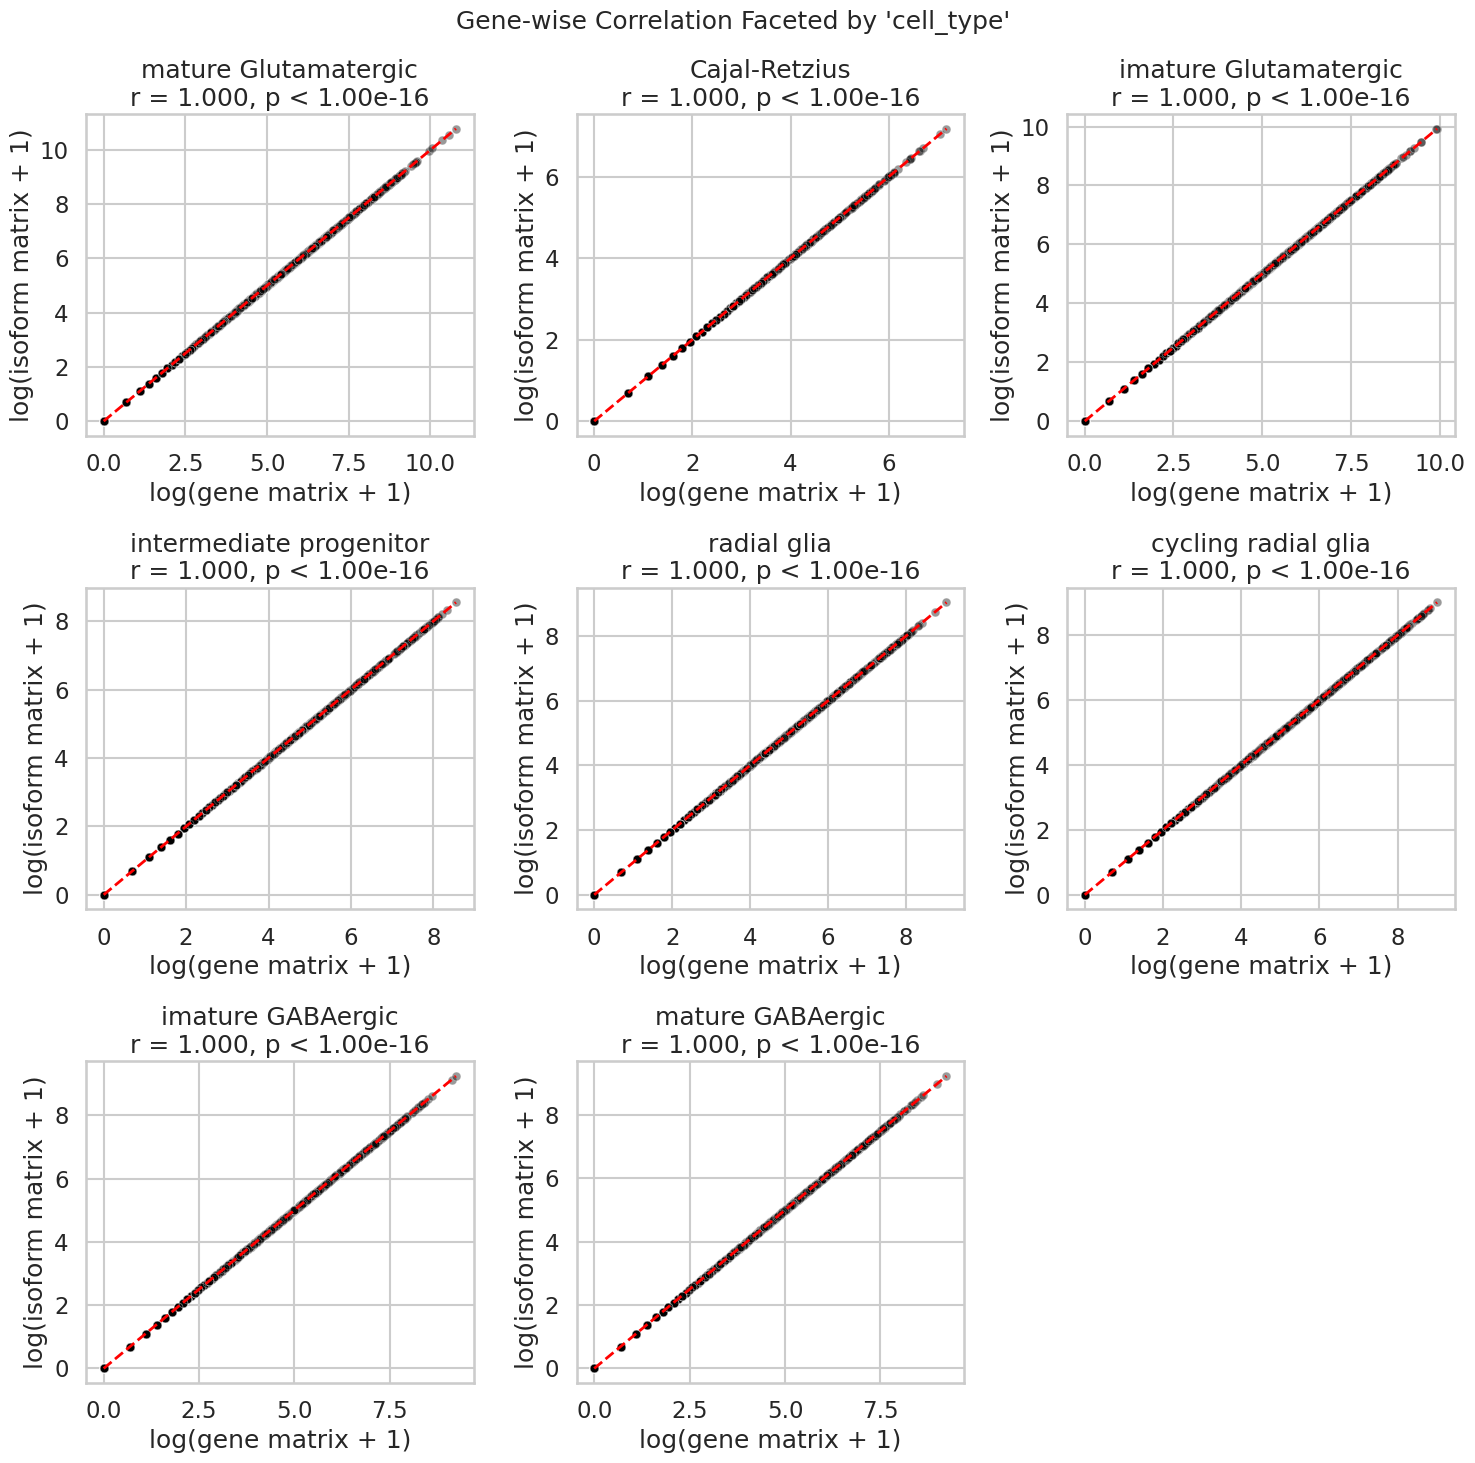

In [16]:
gene_wise_correlation(adata_1=gene_adata, adata_2=combined_mouse_data, label_1="gene matrix", label_2 = "isoform matrix", density_hist = True, facet_obs = "cell_type")

In [17]:
# | export

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def gene_wise_bland_altman(
    adata_1,
    adata_2,
    label_1="Short_Reads",
    label_2="Long_Reads",
    facet_obs=None,
):
    """
    Similar logic to gene_wise_correlation, but produces a Bland–Altman plot of the
    log1p-transformed gene counts. If facet_obs is given, one subplot per category.

    Steps:
     1) (Optionally) convert each AnnData to gene-level if needed.
     2) Sum counts across cells in each AnnData.
     3) Merge on gene_name.
     4) Bland–Altman: difference vs. mean of log1p(counts).

    Parameters
    ----------
    adata_1 : AnnData
    adata_2 : AnnData
        Both should be gene-level or convertible to gene-level (e.g., via get_sot_gene_matrix).
    label_1 : str
        Label for the first dataset in merged outputs & plot axes.
    label_2 : str
        Label for the second dataset in merged outputs & plot axes.
    facet_obs : str or None
        If not None, create one subplot per category in `adata_1.obs[facet_obs]`.

    Returns
    -------
    pd.DataFrame
        - If facet_obs is None: a single DataFrame with columns
          [gene_name, label_1, label_2, log_x, log_y, mean_val, diff_val].
        - If facet_obs is not None: concatenated DataFrame with all categories,
          plus 'facet' indicating each category.
    """

    # ------------------------------------------------------------------
    # 1) Optionally convert each AnnData to gene-level if needed
    #    (Replace these checks with your get_sot_gene_matrix logic.)
    # ------------------------------------------------------------------
    if adata_1.var.index.name is not None and "transcriptId" in adata_1.var.index.name:
        adata_1_gene = get_sot_gene_matrix(adata_1)
    else:
        adata_1_gene = adata_1

    if adata_2.var.index.name is not None and "transcriptId" in adata_2.var.index.name:
        adata_2_gene = get_sot_gene_matrix(adata_2)
    else:
        adata_2_gene = adata_2

    # A helper to sum across cells and merge:
    def _merge_summed(adataA, adataB):
        """
        Sums gene counts in each AnnData across all cells,
        merges on gene_name, and returns the merged DataFrame.
        """
        # Sum across rows (cells)
        countsA = np.array(adataA.X.sum(axis=0)).flatten()
        geneA = adataA.var_names
        countsB = np.array(adataB.X.sum(axis=0)).flatten()
        geneB = adataB.var_names

        dfA = pd.DataFrame({label_1: countsA, "gene_name": geneA})
        dfB = pd.DataFrame({label_2: countsB, "gene_name": geneB})
        merged = pd.merge(dfA, dfB, on="gene_name", how="inner")
        return merged

    # ------------------------------------------------------------------
    # If NO faceting, do a single Bland–Altman plot
    # ------------------------------------------------------------------
    if facet_obs is None:
        merged_df = _merge_summed(adata_1_gene, adata_2_gene)

        # Log-transform
        merged_df["log_x"] = np.log1p(merged_df[label_1])
        merged_df["log_y"] = np.log1p(merged_df[label_2])

        # Bland–Altman: difference vs mean
        merged_df["mean_val"] = (merged_df["log_x"] + merged_df["log_y"]) / 2
        merged_df["diff_val"] = merged_df["log_x"] - merged_df["log_y"]

        mean_diff = merged_df["diff_val"].mean()
        std_diff = merged_df["diff_val"].std(ddof=1)

        # Plot
        sns.set(style="whitegrid", context="talk")
        plt.figure(figsize=(10, 6))

        plt.scatter(
            merged_df["mean_val"],
            merged_df["diff_val"],
            color="black", alpha=0.4, s=40
        )

        # Horizontal lines: mean difference, ±1.96*SD
        plt.axhline(mean_diff, color="red", linestyle="--", linewidth=2,
                    label=f"Mean diff = {mean_diff:.2f}")
        plt.axhline(mean_diff + 1.96 * std_diff, color="blue", linestyle="--", linewidth=1,
                    label=f"+1.96 SD = {(mean_diff + 1.96 * std_diff):.2f}")
        plt.axhline(mean_diff - 1.96 * std_diff, color="blue", linestyle="--", linewidth=1,
                    label=f"-1.96 SD = {(mean_diff - 1.96 * std_diff):.2f}")

        plt.title(f"Bland–Altman Plot (Log1p)\n{label_1} vs {label_2}", fontsize=16)
        plt.xlabel(f"Mean of log({label_1}, {label_2})", fontsize=12)
        plt.ylabel(f"Difference (log_x - log_y)", fontsize=12)

        plt.legend()
        plt.tight_layout()
        plt.show()

        return merged_df

    # ------------------------------------------------------------------
    # If faceting, produce one subplot per category
    # ------------------------------------------------------------------
    else:
        categories = adata_1_gene.obs[facet_obs].unique()
        all_cats_list = []

        # For each category, subset each AnnData, sum, merge
        for cat in categories:
            adata_1_sub = adata_1_gene[adata_1_gene.obs[facet_obs] == cat]
            adata_2_sub = adata_2_gene[adata_2_gene.obs[facet_obs] == cat]

            if adata_1_sub.n_obs == 0 or adata_2_sub.n_obs == 0:
                continue

            merged_df_cat = _merge_summed(adata_1_sub, adata_2_sub)
            if merged_df_cat.empty:
                continue

            # Log-transform
            merged_df_cat["log_x"] = np.log1p(merged_df_cat[label_1])
            merged_df_cat["log_y"] = np.log1p(merged_df_cat[label_2])

            merged_df_cat["mean_val"] = (merged_df_cat["log_x"] + merged_df_cat["log_y"]) / 2
            merged_df_cat["diff_val"] = merged_df_cat["log_x"] - merged_df_cat["log_y"]
            merged_df_cat["facet"] = cat
            all_cats_list.append(merged_df_cat)

        if not all_cats_list:
            print(f"No data for any categories in '{facet_obs}'. Returning empty.")
            return pd.DataFrame()

        big_df = pd.concat(all_cats_list, ignore_index=True)

        # Now we plot each category as a separate subplot
        facet_values = big_df["facet"].unique()
        n_categories = len(facet_values)

        ncols = 3
        nrows = math.ceil(n_categories / ncols)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
        axes = np.ravel(axes) if n_categories > 1 else [axes]

        sns.set(style="whitegrid", context="talk")

        for ax, cat in zip(axes, facet_values):
            subset_df = big_df[big_df["facet"] == cat]
            mean_diff = subset_df["diff_val"].mean()
            std_diff = subset_df["diff_val"].std(ddof=1)

            ax.scatter(
                subset_df["mean_val"], 
                subset_df["diff_val"], 
                color="black", alpha=0.4, s=40
            )

            ax.axhline(mean_diff, color="red", linestyle="--", linewidth=2)
            ax.axhline(mean_diff + 1.96 * std_diff, color="blue", linestyle="--", linewidth=1)
            ax.axhline(mean_diff - 1.96 * std_diff, color="blue", linestyle="--", linewidth=1)

            ax.set_title(f"{cat}", fontsize=12)
            ax.set_xlabel("Mean of log1p counts", fontsize=10)
            ax.set_ylabel("Difference", fontsize=10)

        # Hide any unused subplots
        for idx in range(n_categories, len(axes)):
            axes[idx].axis("off")

        fig.suptitle(f"Bland–Altman by '{facet_obs}'\n({label_1} vs {label_2})", fontsize=16)
        fig.tight_layout()
        plt.show()


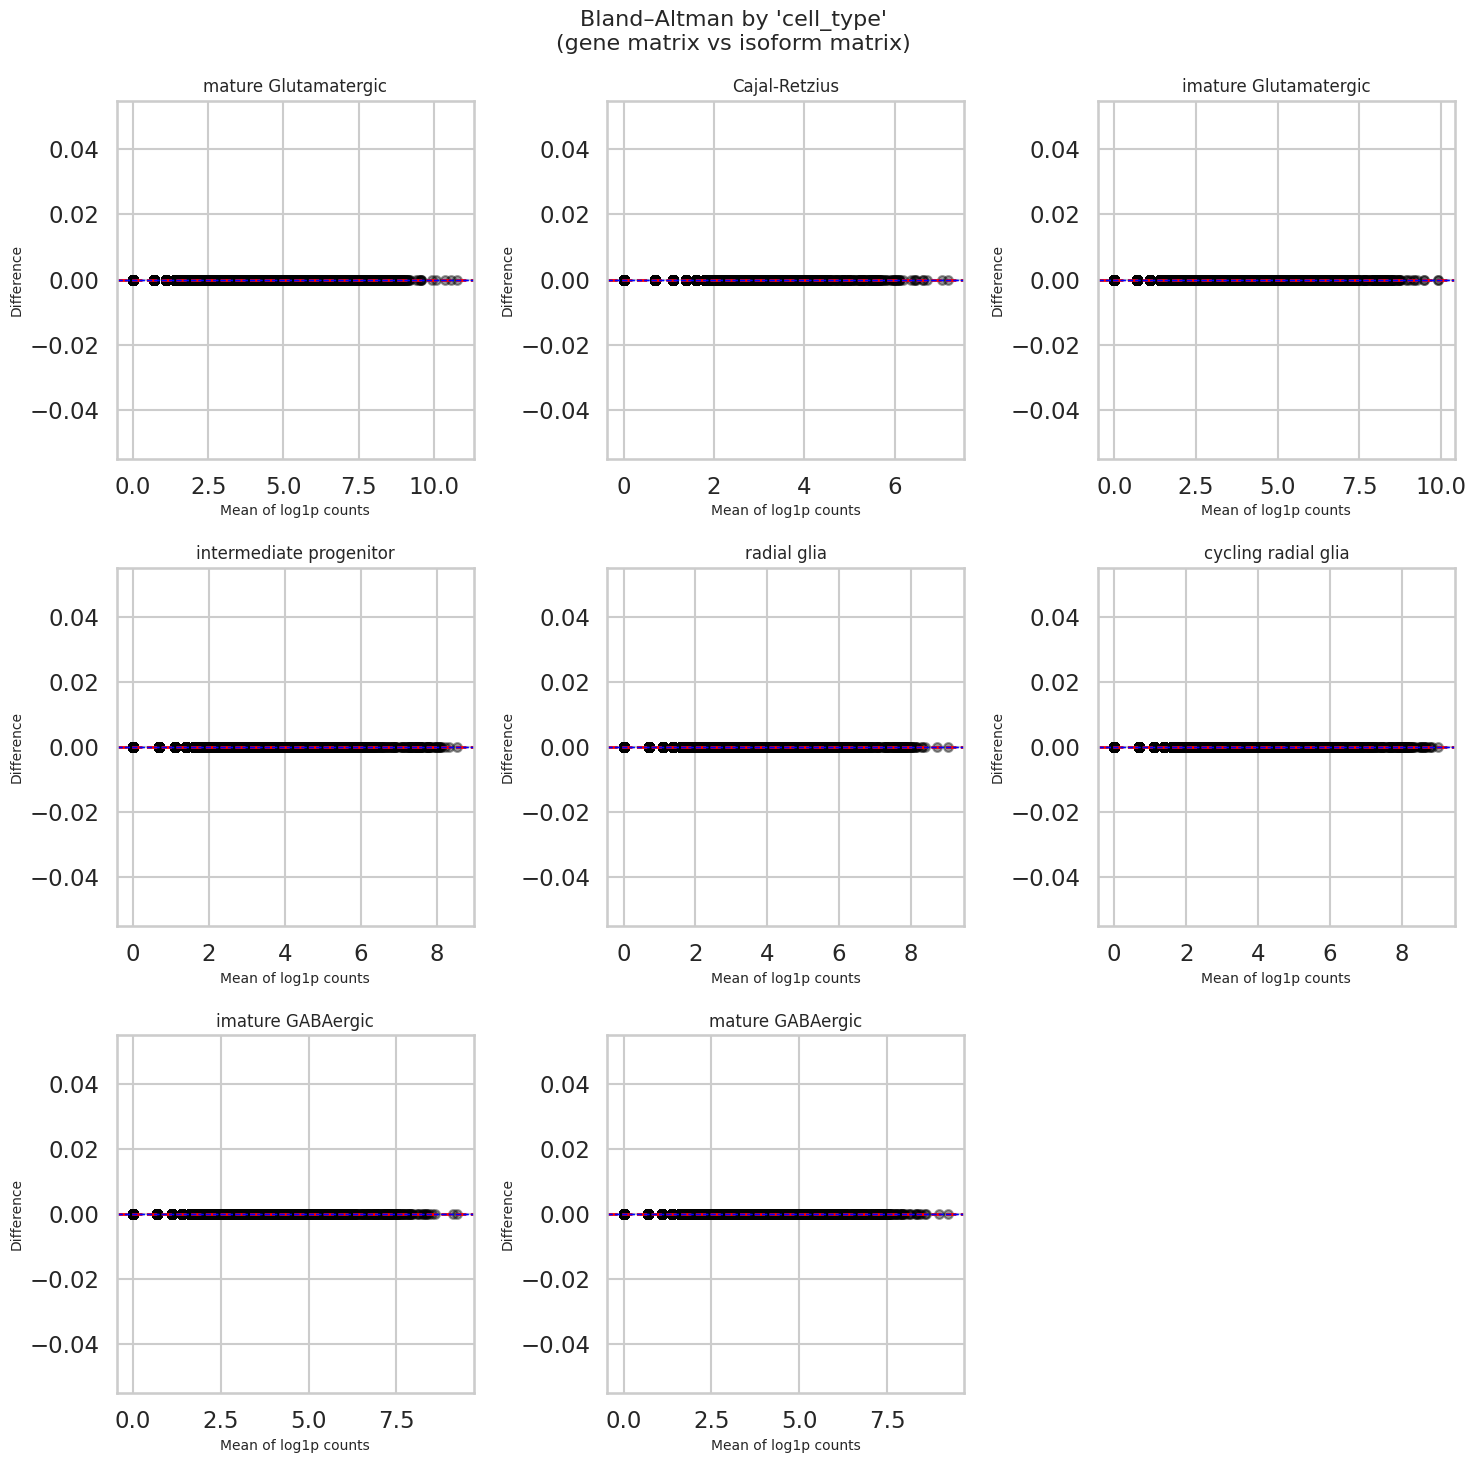

In [18]:
gene_wise_bland_altman(adata_1=gene_adata, adata_2=combined_mouse_data, label_1="gene matrix", label_2 = "isoform matrix", facet_obs = "cell_type")

In [19]:
#| hide
from nbdev.showdoc import *

In [20]:
import nbdev; nbdev.nbdev_export()